In [138]:
import os
import re
import glob
import pickle
import string

from maleo.wizard import Wizard

import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

%matplotlib inline

In [2]:
wiz = Wizard()

In [3]:
pd.set_option('display.max_rows', 10)

In [4]:
# input path
SUPPORT_PATH = "../data/supports"

In [5]:
def read_pickle(path):
    with open(path, 'rb') as f:
        return pickle.load(f)

In [6]:
d_199 = read_pickle(os.path.join(SUPPORT_PATH, "parsed_199.pkl"))
d_6725 = read_pickle(os.path.join(SUPPORT_PATH, "parsed_7003.pkl"))
d_tweets = pd.concat([d_199, d_6725], axis = 0, sort=False)
d_tweets.drop_duplicates(subset="id_tweet", inplace=True)
d_tweets.reset_index(drop=True, inplace=True)

In [7]:
d_label = pd.read_csv("../data/account_labeled/project_12_labels_Thu_Oct_15_2020.csv")

In [8]:
d_label.head()

,ID,Text,Label
0,2337,https://twitter.com/fahrisalam __________name:...,buzzer
1,5329,https://twitter.com/Prof_Kupie __________name:...,buzzer
2,6392,"""https://twitter.com/Syam42933824 __________na...",buzzer
3,2131,https://twitter.com/dwiawatie __________name: ...,buzzer
4,5849,https://twitter.com/saaragih __________name: L...,buzzer


In [9]:
d_label.shape

(3403, 3)

In [10]:
d_tweets.head()

,screen_name,id_tweet,full_text,hashtags,user_mentions,created_at,quote_is_quote_status,quote_screen_name,quote_id_tweet,quote_full_text,quote_hashtags,quote_user_mentions,quote_created_at,in_reply_to_status_id_str,in_reply_to_user_id_str,in_reply_to_screen_name
0,212Ujee2,1272955449160040449,#HapusRUUHIPDariMukaBumi \n#HapusRUUHIPDariMuk...,"[{'text': 'HapusRUUHIPDariMukaBumi', 'indices'...",[],Tue Jun 16 18:13:24 +0000 2020,True,Par3w4_Minang,1272901801516335112,Moncong putih ingin cuci tangan \n\nKata si Po...,[],[],Tue Jun 16 14:40:13 +0000 2020,NaN,NaN,NaN
1,212Ujee2,1272573148974571526,Sampah n benalu\nPerusak demokrasi wajib kita ...,"[{'text': 'BuzzeRpPublicEnemy', 'indices': [59...",[],Mon Jun 15 16:54:16 +0000 2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,212Ujee2,1272242834725208064,Saatnya kita bersatu\nWahai umat Islam\n\n#Sto...,"[{'text': 'Stop_RUUHIP', 'indices': [39, 51]},...",[],Sun Jun 14 19:01:43 +0000 2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,212Ujee2,1267860265694978049,Umat Islam\nHrs diam \nTerus sampai kapan?\nKe...,"[{'text': 'BalikinDanaHaji', 'indices': [104, ...",[],Tue Jun 02 16:46:57 +0000 2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,212Ujee2,1266354000716107780,Hai Pemimpin !!!\nApakah udh ga ada lagi \nPro...,"[{'text': 'DirutBokep', 'indices': [204, 215]}...","[{'screen_name': '__p3jalan____', 'name': 'p3j...",Fri May 29 13:01:36 +0000 2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
d_tweets.shape

(1983967, 16)

In [12]:
d_tweets[d_tweets.screen_name.isin(['urmila__011'])]

,screen_name,id_tweet,full_text,hashtags,user_mentions,created_at,quote_is_quote_status,quote_screen_name,quote_id_tweet,quote_full_text,quote_hashtags,quote_user_mentions,quote_created_at,in_reply_to_status_id_str,in_reply_to_user_id_str,in_reply_to_screen_name
219332,urmila__011,1274370414408425473,Ryamizard: Orang yang Ingin Mengganti Pancasil...,[],[],Sat Jun 20 15:55:58 +0000 2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
219333,urmila__011,1274272204935462913,Yg pingin ikutan salfol utk besok komen disini...,[],[],Sat Jun 20 09:25:43 +0000 2020,True,urmila__011,1274266066772885504,Tilem...\n\nJangan tanya kenapa ngak pake bung...,[],[],Sat Jun 20 09:01:19 +0000 2020,NaN,NaN,NaN
219334,urmila__011,1274266066772885504,Tilem...\n\nJangan tanya kenapa ngak pake bung...,[],[],Sat Jun 20 09:01:19 +0000 2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
219335,urmila__011,1274234503867727872,Ada yg blm salfol ya ama akun keren ini... \n\...,[],"[{'screen_name': 'll_fharez', 'name': 'de'Rezz...",Sat Jun 20 06:55:54 +0000 2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
219336,urmila__011,1274230206698381312,Salfol siang\n\nngak folbek boleh unfol\n\n@Yn...,[],"[{'screen_name': 'Ynos8881', 'name': 'L888$', ...",Sat Jun 20 06:38:49 +0000 2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1872783,urmila__011,1276328574312579072,@angraeni21 Penghasilan dia dr konten terbesar...,[],"[{'screen_name': 'angraeni21', 'name': 'Anggra...",Fri Jun 26 01:36:59 +0000 2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1276328074015981568,1236905751873908736,angraeni21
1872784,urmila__011,1276321866660016131,@Risnabetty14 @QiraniAyara @nafas_cinta79 @The...,[],"[{'screen_name': 'Risnabetty14', 'name': 'Risn...",Fri Jun 26 01:10:20 +0000 2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1276321357131743233,1276076867972239361,Risnabetty14
1872785,urmila__011,1276321493861859328,@RantingPinus @Toto75014110 Sama kita liat2 sj...,[],"[{'screen_name': 'RantingPinus', 'name': 'Rant...",Fri Jun 26 01:08:51 +0000 2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1276321086825619456,1141724784100646912,RantingPinus
1872786,urmila__011,1276321239406010368,@Doni28231984 @Asruleffendylu3 @DrhRukmana @Ay...,[],"[{'screen_name': 'Doni28231984', 'name': 'Doni...",Fri Jun 26 01:07:51 +0000 2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1276321069486374914,1213315709704388609,Doni28231984


In [13]:
# parsing label
d_label.rename(columns={'Label': "label"}, inplace=True)
d_label['url_profile'] = d_label.Text.apply(lambda x: x.split()[0].strip())
d_label['username'] = d_label.url_profile.apply(lambda x: x.split('/')[-1])
d_label = d_label[["username", "label"]]

In [14]:
# 3258 accounts are labeled, the rest are excluded before parsing
d_tweets[d_tweets.screen_name.isin(d_label.username)].screen_name.unique().shape

(3258,)

In [15]:
d_dataset = d_tweets.groupby('screen_name')['full_text'].apply(list)
d_dataset = d_dataset.reset_index()
# join dataset and label
d_dataset = d_dataset.join(d_label.set_index('username'), on='screen_name')
d_dataset = d_dataset.rename(columns={'Label':'label'})
# remove label inactive
d_dataset = d_dataset[d_dataset.label != 'inactive']

In [16]:
d_dataset.loc[:, 'num_tweets'] = d_dataset.full_text.apply(lambda x : len(x))

In [17]:
# using 10 samples
d_dataset['text_used'] = d_dataset.full_text.apply(lambda x: " ".join(x[:10]))

In [83]:
def text_cleansing(title):
    punctuation = '!"#$%&\'()*+,-./:;=?@[\\]^_`{|}~'
    table = str.maketrans(punctuation, ' '*len(punctuation)) #map punctuation to space
    
    # parse hashtag
    title = re.sub(r"([a-z])([A-Z])", r"\1 \2", title)
    # lowercase
    title = title.lower()
    # convert hyperlinks to link
    title = re.sub('http(s):/\/\\S+', '<LINK> ', title)
    # convert @username to username
    title = re.sub('@\w+', '<USERNAME>', title)
    # remove punctuation
    title = title.translate(table)
    # only take string started with alphanum
    title = re.sub("[^(\w|\<\>)]", ' ', title)
    # remove double whitespaces
    title = re.sub('\s+', ' ', title)
    # remove double whitespaces
    title = title.strip()
    
    return title

In [84]:
d_dataset['preprocessed_text'] = d_dataset.text_used.apply(text_cleansing)

In [85]:
d_dataset.loc[0, 'text_used']

'#HariJadiTwitterSaya \n28 Juni 2017 https://t.co/zrb4HSd6tG Penjilat yang Berkedok Agama\n\n#PecatTengkuzulDariMUI\n#PecatTengkuzulDariMUI https://t.co/m575Heqt88 600 Orang Ikut Rapid Test Polri Saat CFD di Jakarta, 5 Orang Reaktif\n\n🤦🤦🤦\nKlo begini nanti ada Konpres ga ya ?\n https://t.co/ohiPQ1ijFl Sebelum kemunculan HRS, tak ada catatan mengenai “konflik” antara habaib dan nahdliyin kecuali kasus individual Habib Husein al-Habsyi yg menyerukan penggulingan Gus Dur dari kursi kepresidenan, pada 2001.\n@GusNadjb https://t.co/U2E5V3dKbN Selamat Ulang Tahun ke-59\nPresiden Republik Indonesia\nPanglima Tertinggi\nBapak Joko Widodo / @jokowi \n\nSemoga\nSelalu diberikan Kesehatan, Kekuatan dan Kesuksesan menjadi Pemimpin dalam Memakmurkan dan Mensejahterakan Bangsa Indonesia\n\n#HUTJokowi\n#MenujuIndonesiaMaju https://t.co/r49PZr8BCK Ada apa dengan Almamater Ku\nKenapa ada Tagar 👇\n#InstitutPalingBorjuis IPB https://t.co/2dAqvkZhte Arie Poyuono : "isu PKI dimainkan Kadrun" ditujukan pad

In [86]:
d_dataset.loc[0, 'preprocessed_text']

'hari jadi twitter saya 28 juni 2017 <LINK> g penjilat yang berkedok agama pecat tengkuzul dari mui pecat tengkuzul dari mui <LINK> 600 orang ikut rapid test polri saat cfd di jakarta 5 orang reaktif klo begini nanti ada konpres ga ya <LINK> pq1ij fl sebelum kemunculan hrs tak ada catatan mengenai konflik antara habaib dan nahdliyin kecuali kasus individual habib husein al habsyi yg menyerukan penggulingan gus dur dari kursi kepresidenan pada 2001 <USERNAME> nadjb <LINK> kb n selamat ulang tahun ke 59 presiden republik indonesia panglima tertinggi bapak joko widodo <USERNAME> semoga selalu diberikan kesehatan kekuatan dan kesuksesan menjadi pemimpin dalam memakmurkan dan mensejahterakan bangsa indonesia hutjokowi menuju indonesia maju <LINK> ada apa dengan almamater ku kenapa ada tagar institut paling borjuis ipb <LINK> aqvk zhte arie poyuono isu pki dimainkan kadrun ditujukan pada kadal gurun kadrun kini kita bisa tahu mana kadal dan mana orang pks sarang kadrun rekayasa didzolimi <LI

In [87]:
d_train = d_dataset.dropna()
d_test = d_dataset[d_dataset.label.isna()]

In [88]:
d_train = d_train[["screen_name", "full_text", "text_used", "preprocessed_text", "label"]]

In [89]:
d_train.loc[:, 'label_encoded'] = d_train.label.map({'buzzer': 1, 'non-buzzer': 0})

In [90]:
d_train.head()

,screen_name,full_text,text_used,preprocessed_text,label,label_encoded
1,02Trus,[RT @SaveMoslem1: *Asyeeekkk.... PDIP kena jeb...,RT @SaveMoslem1: *Asyeeekkk.... PDIP kena jeba...,rt <USERNAME> moslem1 asyeeekkk pdip kena jeba...,buzzer,1
3,0b4tk3lu4r94,[Sebentar....bentar gue hrs inget2 nih berukny...,Sebentar....bentar gue hrs inget2 nih beruknya...,sebentar bentar gue hrs inget2 nih beruknya sa...,non-buzzer,0
5,0mega01,[Tayang #programfolback \n#MutualMilenial \nFo...,Tayang #programfolback \n#MutualMilenial \nFol...,tayang programfolback mutual milenial follow <...,buzzer,1
6,0v4lt1n3_,[..dan produk yang pro-Zionis. \n\nSayang.. Te...,..dan produk yang pro-Zionis. \n\nSayang.. Ter...,dan produk yang pro zionis sayang terlambat se...,non-buzzer,0
8,17Mutawakkil,"[Dengarkan podcast saya, Sambatan Harapan di G...","Dengarkan podcast saya, Sambatan Harapan di Go...",dengarkan podcast saya sambatan harapan di goo...,non-buzzer,0


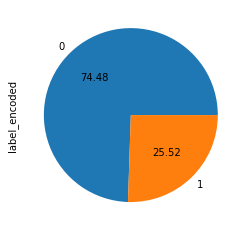

In [91]:
d_train.label_encoded.value_counts().plot(kind='pie', autopct='%.2f')

### Exprimenting with simple algorithm

In [92]:
tfidf = TfidfVectorizer()

In [93]:
text_tfidf = tfidf.fit_transform(d_train.preprocessed_text)

In [137]:
text_tfidf.shape

(3099, 64690)

In [130]:
X_train, X_test, y_train, y_test = train_test_split(text_tfidf, d_train.label_encoded, test_size=0.2, random_state=123)

In [131]:
y_train.value_counts()

0    1838
1     641
Name: label_encoded, dtype: int64

In [132]:
y_test.value_counts()

0    470
1    150
Name: label_encoded, dtype: int64

In [133]:
def scoring(y_test, y_pred):
    
    acc = accuracy_score(y_test, y_pred)
    pre = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    print(f"accuracy: {acc:.2f} | precision: {pre:.2f} | recall: {rec:.2f} | f score: {f1:.2f}")

In [134]:
model = BernoulliNB()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
scoring(y_test, y_pred)

accuracy: 0.78 | precision: 0.60 | recall: 0.21 | f score: 0.32


In [135]:
model = SVC(gamma='scale', kernel='linear')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
scoring(y_test, y_pred)

accuracy: 0.85 | precision: 0.74 | recall: 0.57 | f score: 0.64


In [136]:
model = RandomForestClassifier(n_estimators=100)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
scoring(y_test, y_pred)

accuracy: 0.82 | precision: 0.74 | recall: 0.43 | f score: 0.54


In [140]:
model = GradientBoostingClassifier(n_estimators=200)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
scoring(y_test, y_pred)

accuracy: 0.84 | precision: 0.73 | recall: 0.55 | f score: 0.63


In [141]:
model = AdaBoostClassifier(n_estimators=400)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
scoring(y_test, y_pred)

accuracy: 0.81 | precision: 0.63 | recall: 0.58 | f score: 0.60
